# Проект: классификация

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

Банки хранят огромные объёмы информации о своих клиентах. Эти данные можно использовать для того, чтобы оставаться на связи с клиентами и индивидуально ориентировать их на подходящие именно им продукты или банковские предложения.

Обычно с выбранными клиентами связываются напрямую через разные каналы связи: лично (например, при визите в банк), по телефону, по электронной почте, в мессенджерах и так далее. Этот вид маркетинга называется прямым маркетингом. На самом деле, прямой маркетинг используется для взаимодействия с клиентами в большинстве банков и страховых компаний. Но, разумеется, проведение маркетинговых кампаний и взаимодействие с клиентами — это трудозатратно и дорого.

→ Банкам хотелось бы уметь выбирать среди своих клиентов именно тех, которые с наибольшей вероятностью воспользуются тем или иным предложением, и связываться именно с ними.

**Бизнес-задача**: определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счёт этого повысить результативность маркетинговой кампании.

**Техническая задача** для вас как для специалиста в Data Science: построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.

Данные о клиентах банка:

- age (возраст);
- job (сфера занятости);
- marital (семейное положение);
- education (уровень образования);
- default (имеется ли просроченный кредит);
- housing (имеется ли кредит на жильё);
- loan (имеется ли кредит на личные нужды);
- balance (баланс).

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

- contact (тип контакта с клиентом);
- month (месяц, в котором был последний контакт);
- day (день, в который был последний контакт);
- duration (продолжительность контакта в секундах).

Прочие признаки:

- campaign (количество контактов с этим клиентом в течение текущей кампании);
- pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- previous (количество контактов до текущей кампании)
- poutcome (результат прошлой маркетинговой кампании).

И, разумеется, наша целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

### Задание 1

In [3]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


### Задание 2

In [6]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

### Задание 3

In [7]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].str.replace(' ', '').str.replace(',', '.').str.replace('$', '').astype('float')
round(df['balance'].mean(), 3)

1529.129

### Задание 4

In [8]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df.loc[(df['balance'].isnull()==True),'balance']=df['balance'].median()
round(df['balance'].mean(), 3)

1526.936

### Задание 5

In [9]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
m_job = df['job'].mode()[0]
m_edu = df['education'].mode()[0]
df.loc[(df['job']=='unknown'),'job']=df['job'].mode()[0]
df.loc[(df['education']=='unknown'),'education']=df['education'].mode()[0]
round(df.loc[(df['job']==m_job) & (df['education']==m_edu), 'balance'].mean(), 3)

1598.883

### Задание 6

In [10]:
# удалите все выбросы для признака balance

# функция по поиску выбросов по методу Тьюки
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    print(f'Нижняя и верхняя границы: {lower_bound} и {upper_bound}')
    return outliers, cleaned

outliers, df = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {df.shape[0]}')

Нижняя и верхняя границы: -2241.0 и 4063.0
Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

deposit
no     5424
yes    4681
Name: count, dtype: int64

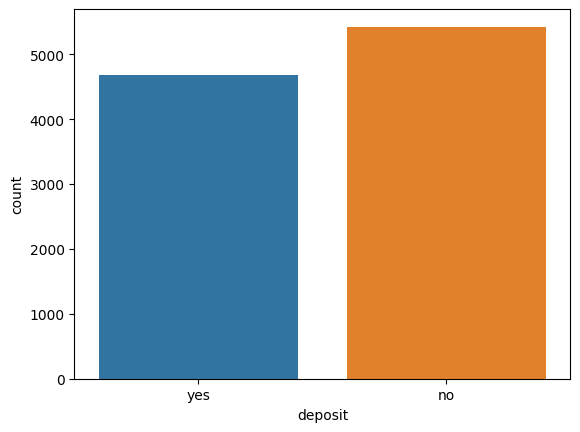

In [11]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
display(df['deposit'].value_counts())
sns.countplot(data=df, x='deposit');

### Задания 2 и 3

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


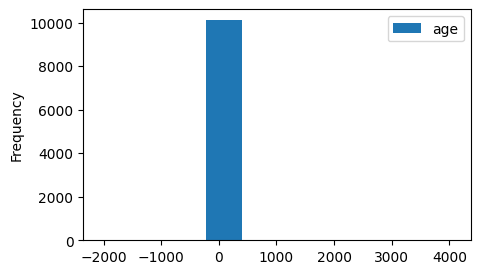

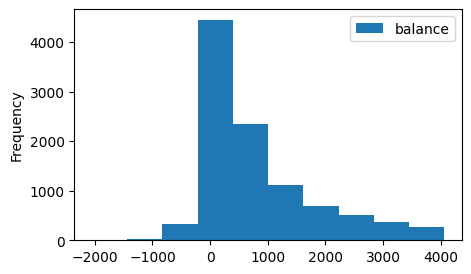

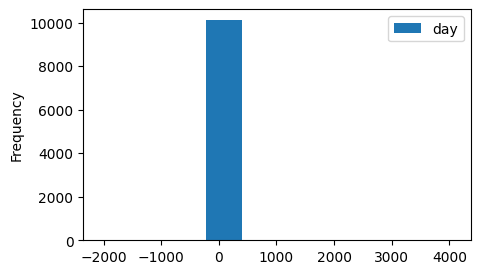

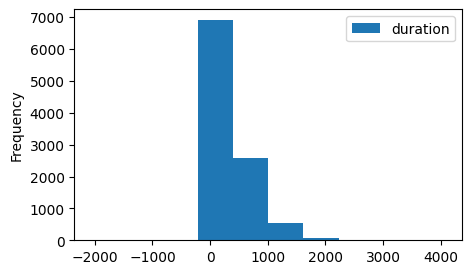

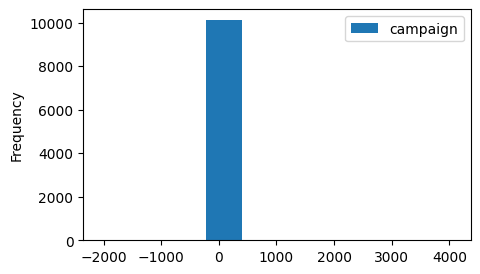

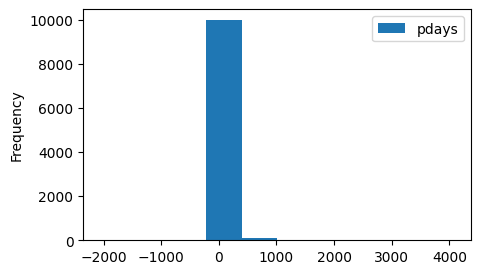

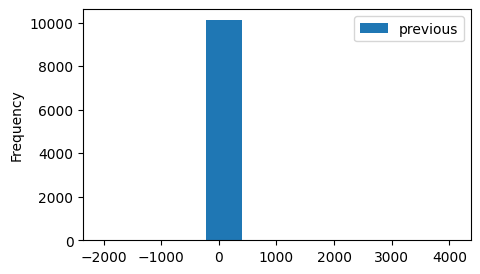

In [12]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
display(df.describe())
num_cols = df._get_numeric_data().columns
for col in num_cols:
    ax = df.plot.hist(column=[col], figsize=(5, 3))

### Задания 4 и 5

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


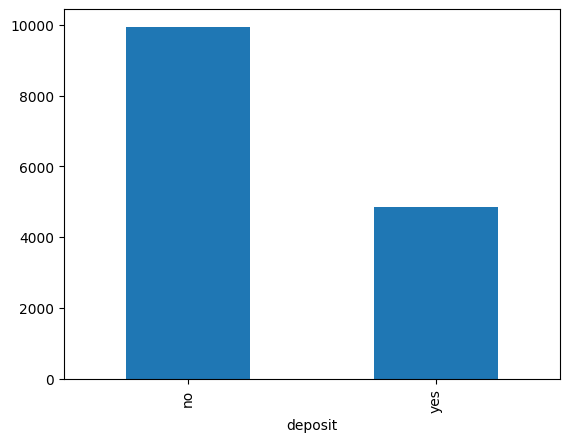

In [13]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
display(df.describe(include = 'object'))
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    ax = df[col].value_counts().plot.bar()

### Задание 6

In [14]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
df.groupby('poutcome')['deposit'].value_counts()

poutcome  deposit
failure   no          562
          yes         547
other     yes         265
          no          216
success   yes         861
          no           84
unknown   no         4562
          yes        3008
Name: count, dtype: int64

### Задание 7

In [15]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
month_rate = []
for month in df['month'].unique():
    value = df[(df['month'] == month) & (df['deposit'] == 'no')]['deposit'].shape[0] / df[(df['month'] == month)]['deposit'].shape[0]
    print(month, value)

may 0.6786396637371036
jun 0.5489130434782609
jul 0.5895627644569816
aug 0.5595667870036101
oct 0.18507462686567164
nov 0.5846153846153846
dec 0.0967741935483871
jan 0.6081504702194357
feb 0.45557122708039494
mar 0.10126582278481013
apr 0.3819277108433735
sep 0.16546762589928057


### Задание 8

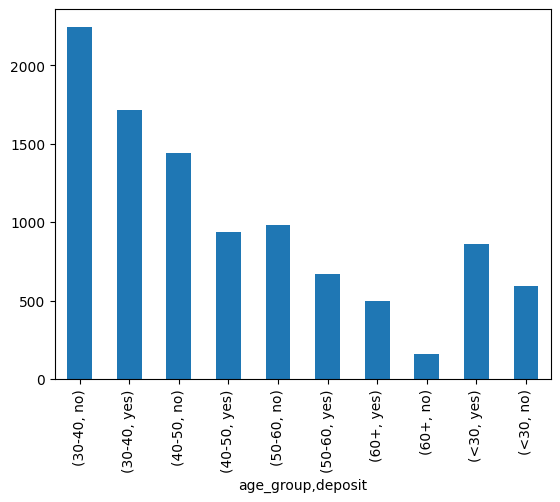

In [16]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def find_age_group(age):
    if age < 30:
        return '<30'
    elif age >= 30 and age < 40:
        return '30-40'
    elif age >= 40 and age < 50:
        return '40-50'
    elif age >= 50 and age < 60:
        return '50-60'    
    elif age >= 60:
        return '60+'

df['age_group'] = df['age'].apply(find_age_group)

data = df.groupby('age_group')['deposit'].value_counts()
ax = data.plot(kind='bar')

### Задания 9 и 10

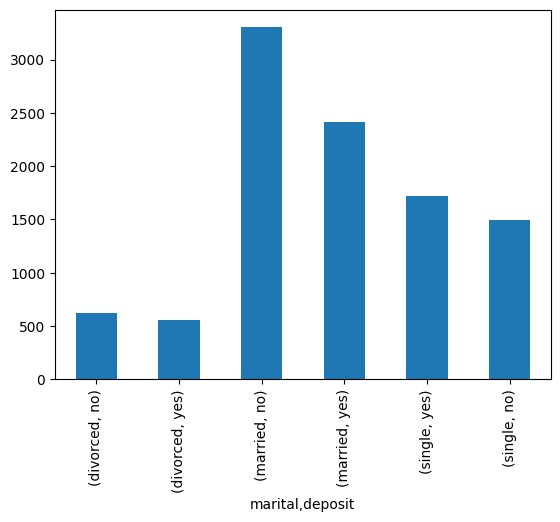

In [17]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
data = df.groupby('marital')['deposit'].value_counts()
ax = data.plot.bar()

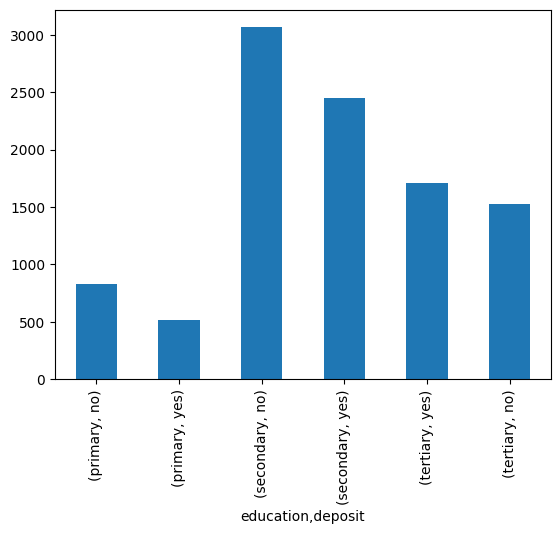

In [18]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
data = df.groupby('education')['deposit'].value_counts()
ax = data.plot.bar()

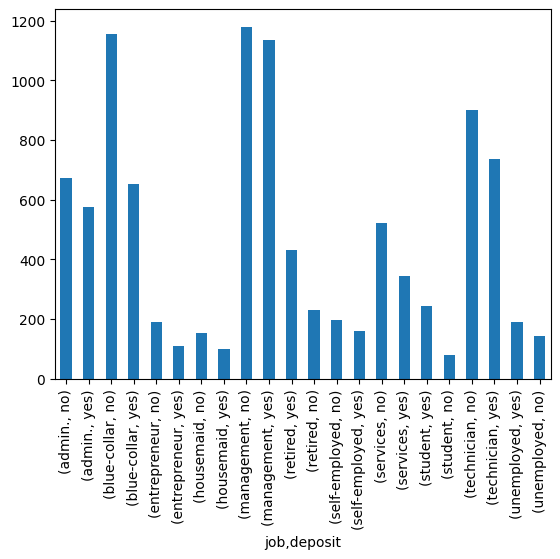

In [19]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
data = df.groupby('job')['deposit'].value_counts()
ax = data.plot.bar()

### Задание 11

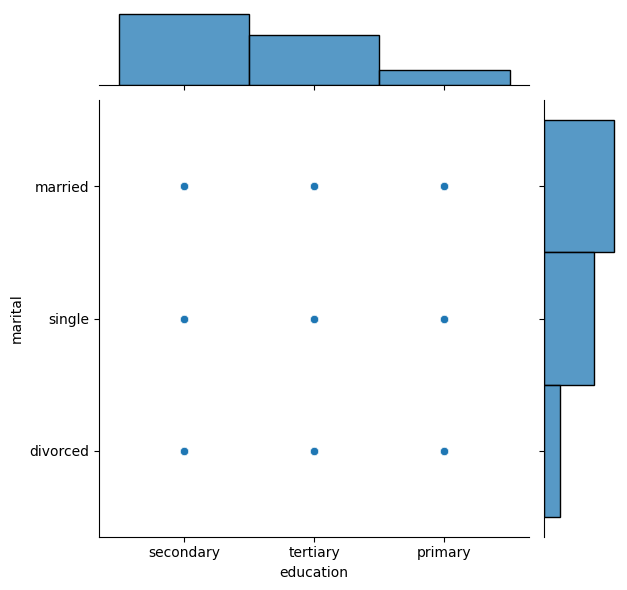

In [20]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
data=df[df['deposit']=='yes']
ax = sns.jointplot(data=data, x='education', y='marital')

## Часть 3: преобразование данных

### Задание 1

In [21]:
# преобразуйте уровни образования
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['education'] = le.fit_transform(df['education'])

df['education'].sum()

11995

### Задания 2 и 3

In [22]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df['age_group'] = le.fit_transform(df['age_group'])

df['deposit'] = le.fit_transform(df['deposit'])
print(df['deposit'].std())

df['default'] = le.fit_transform(df['default'])
df['housing'] = le.fit_transform(df['housing'])
df['loan'] = le.fit_transform(df['loan'])
print(df['default'].mean()+df['housing'].mean()+df['loan'].mean())

0.4986712532452124
0.6354280059376547


### Задание 4

In [23]:
# создайте дамми-переменные
d_cols = ['job', 'marital', 'contact', 'month', 'poutcome']
d_df = pd.get_dummies(df[d_cols])
df = pd.concat([d_df, df], axis=1)
df.shape

(10105, 51)

In [24]:
df.drop(d_cols, axis=1, inplace=True)

### Задания 5 и 6

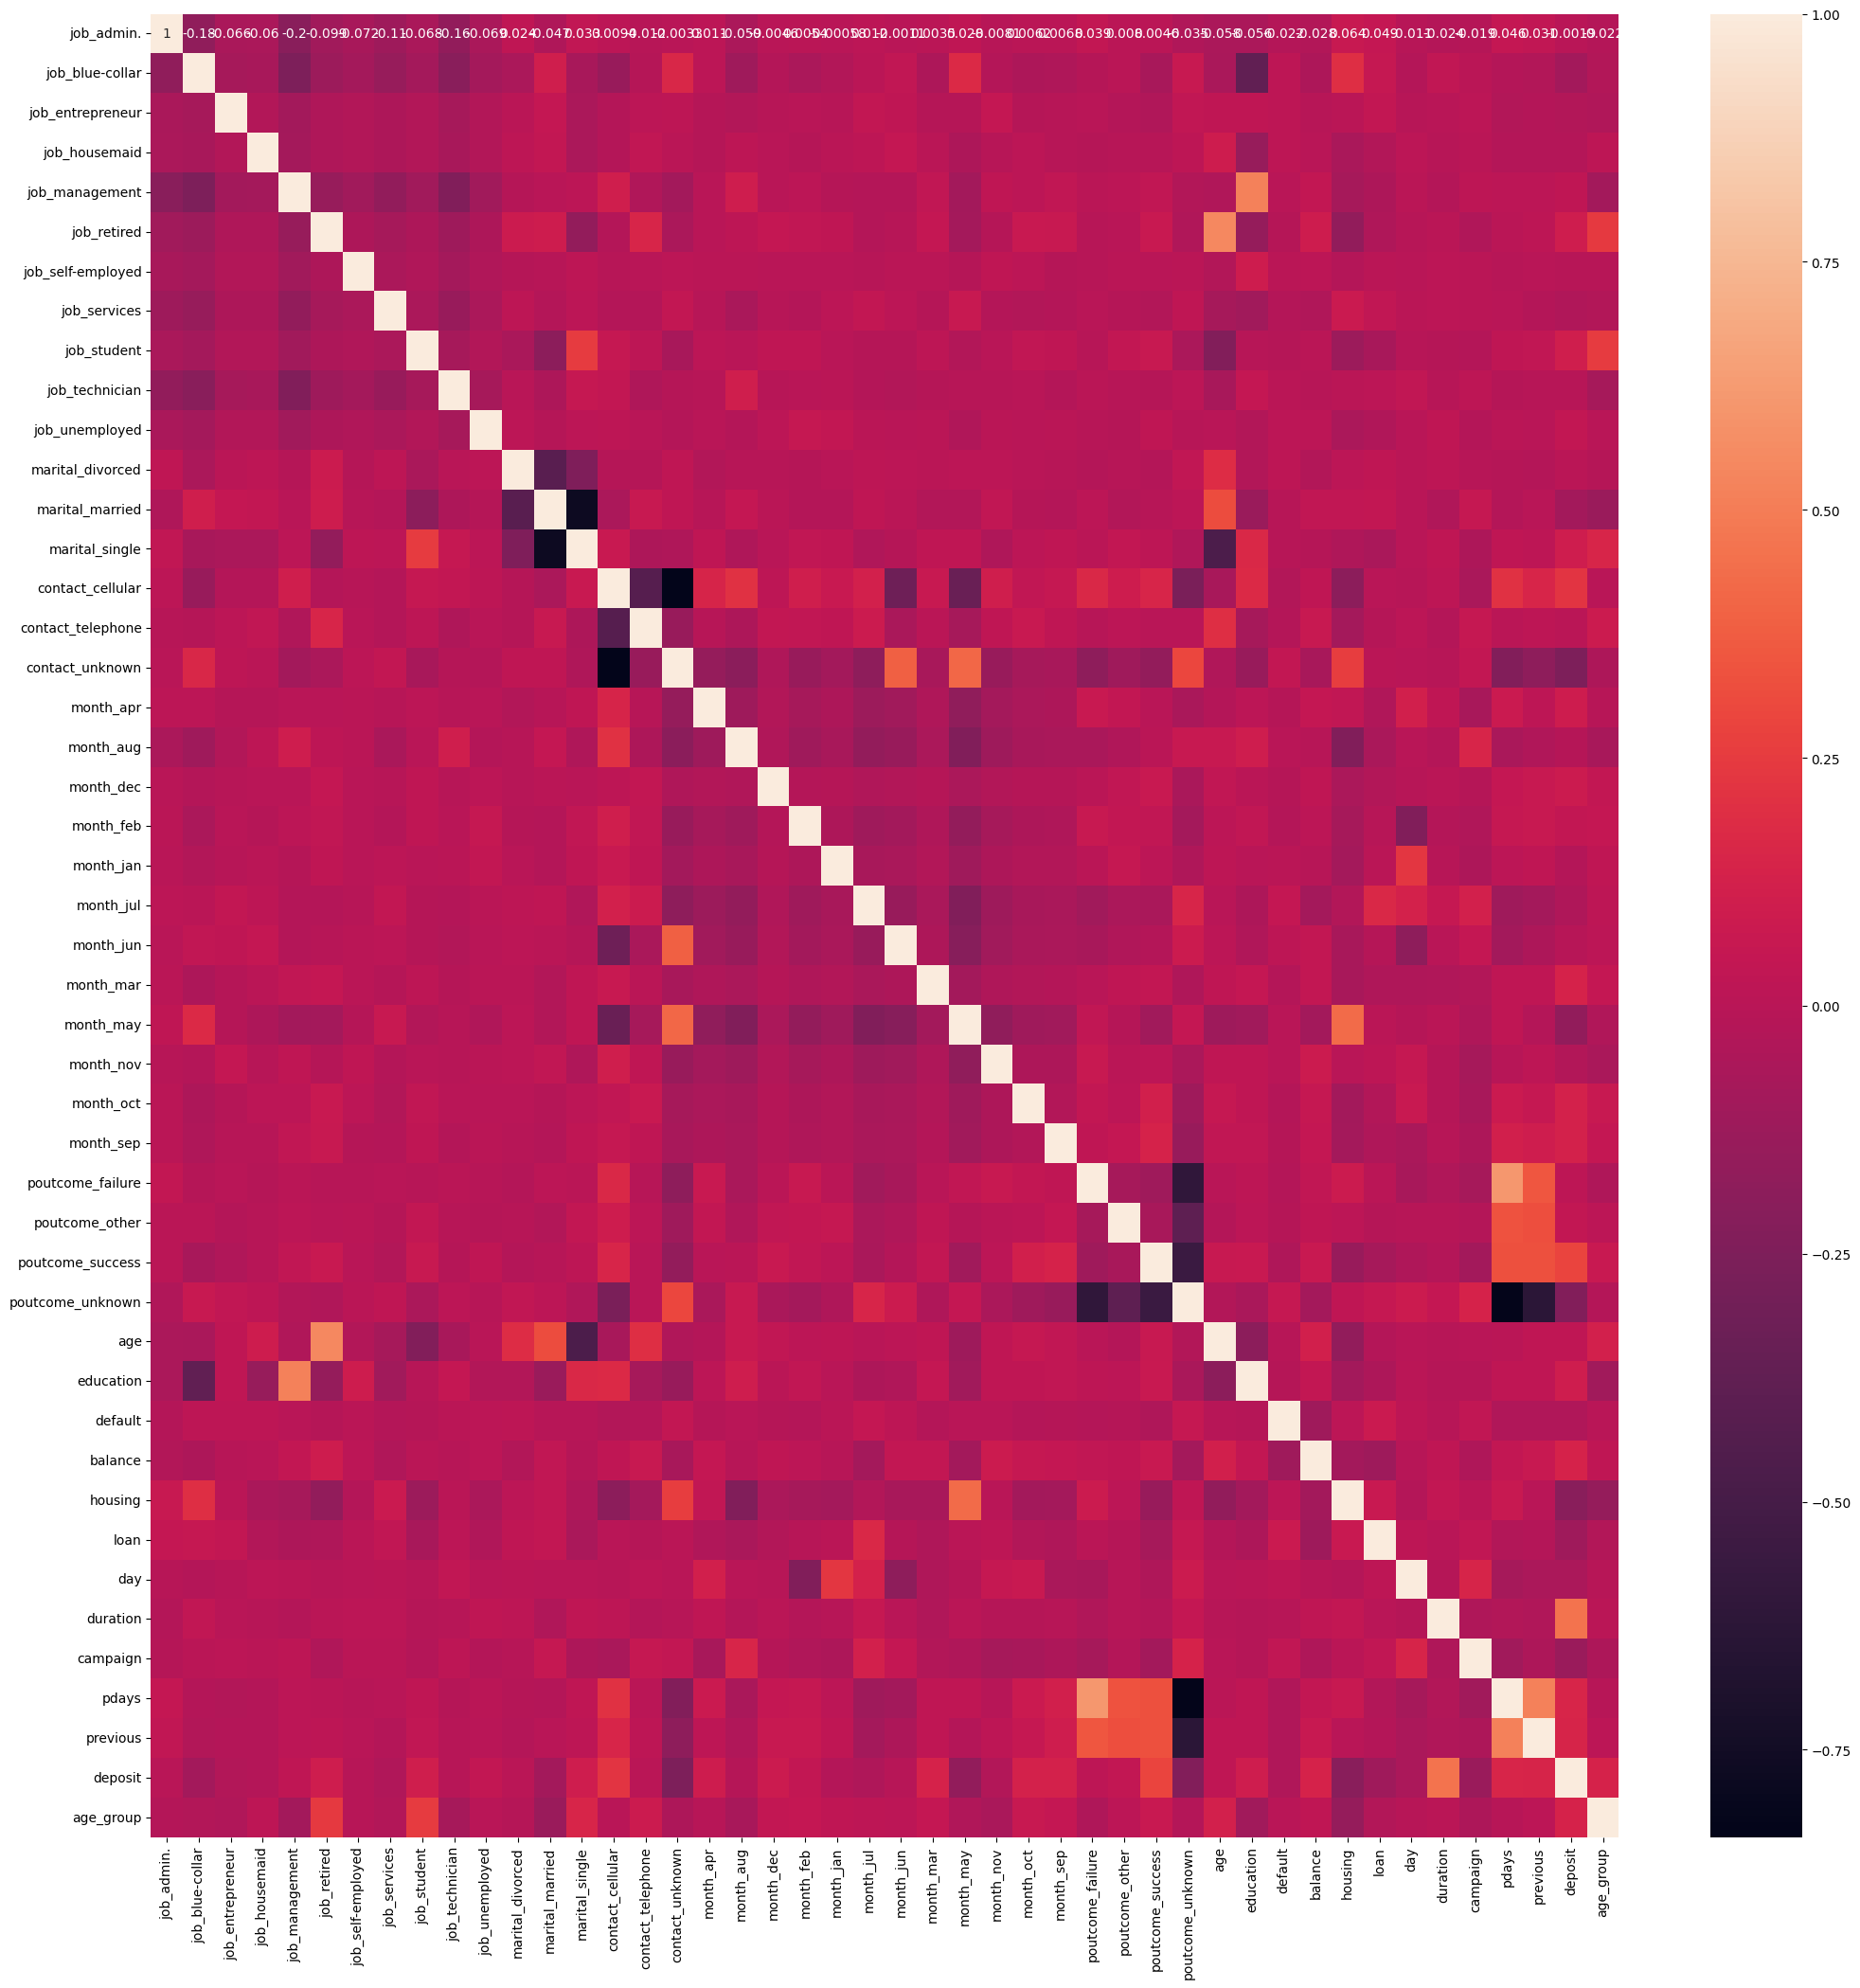

In [25]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
corr = df.corr()
#plt.figure(figsize=(25,25))
#sns.heatmap(corr,fmt='.2f',annot=True, center=0)
fig, ax = plt.subplots(figsize = (25, 25))
sns.heatmap(corr, annot=True);

Text(0.5, 1.0, 'Корреляция с целевыи признаком')

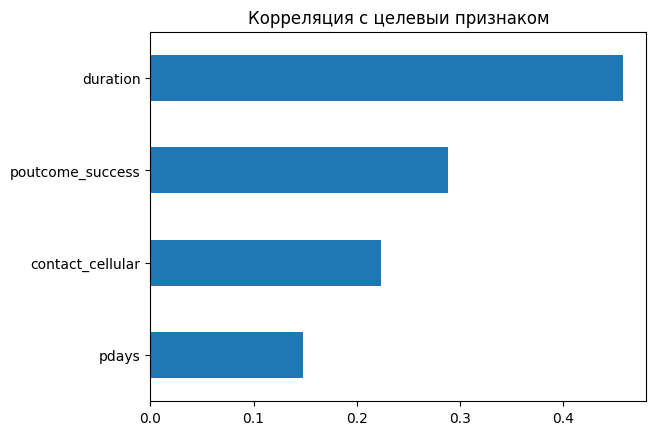

In [26]:
corr['deposit'].sort_values()[-5:-1].plot.barh()
plt.title('Корреляция с целевыи признаком')

### Задания 7 и 8

In [27]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)
X_test.shape

(3335, 45)

In [28]:
# рассчитайте необходимые показатели
y_test.mean()

0.46326836581709147

### Задание 9

In [29]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
features = selector.get_feature_names_out()
print(features)

X_train = X_train[['balance', 'contact_cellular', 'contact_unknown', 'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown',  'housing', 'duration', 'campaign', 'pdays', 'previous', 'age_group']]
X_test = X_test[['balance', 'contact_cellular', 'contact_unknown', 'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown',  'housing', 'duration', 'campaign', 'pdays', 'previous', 'age_group']]

['contact_cellular' 'contact_unknown' 'month_mar' 'month_may' 'month_oct'
 'month_sep' 'poutcome_success' 'poutcome_unknown' 'balance' 'housing'
 'duration' 'campaign' 'pdays' 'previous' 'age_group']


### Задание 10

In [30]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_test_scaled[:,0].mean().round(2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [40]:
# обучите логистическую регрессию и рассчитайте метрики качества
#Создаём объект класса LogisticRegression
log_reg = linear_model.LogisticRegression(random_state=42, max_iter=1000, solver='sag')
#Обучаем модель, минизируя logloss
log_reg.fit(X_train_scaled, y_train)
y_pred = log_reg.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335



### Задания 2,3,4

In [54]:
# обучите решающие деревья, настройте максимальную глубину
#Создаём объект класса DecisionTreeClassifier
dt_clf = tree.DecisionTreeClassifier(
    max_depth=6, 
    random_state=42
)
#Обучаем дерево решений по алгоритму CART
dt_clf.fit(X_train_scaled, y_train)
y_pred = log_reg.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_pred))
y_pred = log_reg.predict(X_train_scaled)
print(metrics.classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.83      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770



### Задание 5

In [56]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

param_grid = {'min_samples_split': [2, 5, 7, 10],#тип регурялизации
              'max_depth': [3,5,7], #алгоритм оптимизации
              }

grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
grid_search.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))
y_test_pred = grid_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.81
f1_score на тестовом наборе: 0.80


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [34]:
# обучите на ваших данных случайный лес

### Задания 2 и 3

In [35]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

### Задание 4

In [36]:
# объедините уже известные вам алгоритмы с помощью стекинга 

### Задание 5

In [37]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [38]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna